# EXPERIMENT 2
---
### Model Architecture: CascadedLSTM (biLSTM->LSTM)
### Dataset: Cairo

### Parameters
- INPUT_DIM = 1000
- N_HIDDEN = 64
- MAX_LENGTH = 2000 (fixed)
- NO_ACTIVITIES = 8 (cairo fixed)
- OPTIMIZER = ADAM (lr = 0.001)
- TOTAL EPOCHS = 30

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
#imports
import os 
import pickle
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

#tensorflow
import tensorflow as tf
from keras.layers import Dense, LSTM, Bidirectional, RNN
from keras.layers.embeddings import Embedding
from keras.models import Sequential
DATA_PATH = '/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/PP_Data/'

Mounted at /content/drive/


In [ ]:
def getData(datasetName):
    X = np.load(f"{DATA_PATH}{datasetName}_X.npy", allow_pickle=True)
    Y = np.load(f"{DATA_PATH}{datasetName}_Y.npy", allow_pickle=True)
    enc_dec = np.load(f"{DATA_PATH}/{datasetName}_ENCDEC.npy", allow_pickle=True)
    return X, Y, enc_dec
X, y, (idx2act, idx2obs, act2idx, obs2idx) = getData('cairo')

In [ ]:
def get_class_acc(X, y, model, idx2act):
  preds = np.array(np.argmax(model.predict(X, verbose=1), axis=-1), dtype=np.int32)
  targets = np.array(y, dtype=np.int32)
  
  print("Classwise accuracy: ")
  totals = {}
  correct = {}
  for i in range(len(idx2act)):
    totals[i] = 1
    correct[i] = 0
  for each in targets: 
    totals[each]+=1
  for i in range(len(idx2act)):
    if totals[i] != 1:
      totals[i] -= 1
  for i, each in enumerate(preds): 
    if each == targets[i]:
        correct[each]+=1
  for i, each in enumerate(idx2act):
    print(f"Model accuracy for predicting {each}: {correct[i]}/{totals[i]} || {round(correct[i]/totals[i]*100, 2)}%")

  print('-'*120)
  m = confusion_matrix(targets, preds)
  fig, ax = plt.subplots(figsize=(13,10))
  sns.heatmap(m, annot=True, ax=ax)
  ax.set(xticklabels=idx2act, yticklabels=idx2act)
  plt.show()
  print('-'*120)

In [ ]:
def plot_history(dict):
  # summarize history for accuracy
  plt.figure(figsize=(10,10))
  plt.plot(dict['accuracy'])
  plt.plot(dict['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.figure(figsize=(10,10))
  plt.plot(dict['loss'])
  plt.plot(dict['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper left')
  plt.show()

In [ ]:
def run(X, y, idx2act, model, save_as, EPOCHS=10):
  print("-"*100)
  print(" > REPORT")
  print("-"*100)
  # TEST SPLIT
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1)

  print('Training set distribution')
  fig, ax = plt.subplots(figsize=(15,5))
  train_y_df = pd.DataFrame({'y' : np.array(y_train, dtype=np.float32)})
  sns.countplot(train_y_df.y, ax=ax)
  ax.set(xticklabels=idx2act)
  plt.show()
  print('Test set distribution')
  fig2, ax2 = plt.subplots(figsize=(15,5))
  test_y_df = pd.DataFrame({'y' : np.array(y_test, dtype=np.float32)})
  sns.countplot(test_y_df.y, ax=ax2)
  ax2.set(xticklabels=idx2act)
  plt.show()
  
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)
  
  # KFOLD SETUP
  X_train_np = np.array(X_train, dtype=np.float32)
  y_train_np = np.array(y_train, dtype=np.float32)
  skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
  # KFOLD LOOP
  overall_acc = []
  
  agg_hist={'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
  for i, (train, test) in enumerate(skf.split(X_train_np, y_train_np)):
    print(f'Fold >> {i+1}')
    X_train_ = tf.convert_to_tensor(X_train_np[train], dtype=tf.float32)
    Y_train_ = tf.convert_to_tensor(y_train_np[train], dtype=tf.float32)
    X_test_ = tf.convert_to_tensor(X_train_np[test], dtype=tf.float32)
    Y_test_ = tf.convert_to_tensor(y_train_np[test], dtype=tf.float32)
    print(f"Begin training ...")

    #callbacks
    filepath = f"/content/drive/My Drive/Research/Deeplearning-in-IoT-systems/Experiments/Models/{save_as}.h5"
    history = model.fit(X_train_, Y_train_, epochs=EPOCHS, batch_size=64, verbose=1, callbacks=[], validation_split=0.2)
    agg_hist['loss'].extend(history.history['loss'])
    agg_hist['val_loss'].extend(history.history['val_loss'])
    agg_hist['accuracy'].extend(history.history['accuracy'])
    agg_hist['val_accuracy'].extend(history.history['val_accuracy'])
    print(f"Begin evalutaion ...")
    scores = model.evaluate(X_test_, Y_test_, batch_size=64, verbose=1)
    print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
    overall_acc.append(scores[1]*100)
    print()

  model.save(filepath)
  print('HISTORY')
  plot_history(agg_hist)
  print()

  print('Test set evalutaion')
  scores = model.evaluate(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), batch_size=64, verbose=1)
  print('%s: %.2f%%' % (model.metrics_names[1], scores[1] * 100))
  print()
  print('Activity accuracy training set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_train, dtype=np.float32)), tf.convert_to_tensor(np.array(y_train, dtype=np.float32)), model, idx2act)
  print()
  print('Activity accuracy test set')
  print('-'*80)
  get_class_acc(tf.convert_to_tensor(np.array(X_test, dtype=np.float32)), tf.convert_to_tensor(np.array(y_test, dtype=np.float32)), model, idx2act)

In [ ]:
# biLSTM 
def get_model(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER):
  model = Sequential(name='CascadeLSTM_biLSTM_LSTM')
  model.add(Embedding(INPUT_DIM, N_HIDDEN, input_length=MAX_LENGTH, mask_zero=True))
  model.add(Bidirectional(LSTM(N_HIDDEN, return_sequences=True)))
  model.add(LSTM(N_HIDDEN))
  model.add(Dense(NO_ACTIVITIES, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
#Arbitary high dim
INPUT_DIM = 1000 
#2n
N_HIDDEN = 64
MAX_LENGTH = 2000
NO_ACTIVITIES = len(idx2act)
OPTIMIZER = 'adam'

In [ ]:
model = get_model(INPUT_DIM, N_HIDDEN, MAX_LENGTH, NO_ACTIVITIES, OPTIMIZER)

Model: "CascadeLSTM_biLSTM_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 2000, 128)         66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
Total params: 179,976
Trainable params: 179,976
Non-trainable params: 0
_________________________________________________________________


----------------------------------------------------------------------------------------------------
 > REPORT
----------------------------------------------------------------------------------------------------
Training set distribution


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


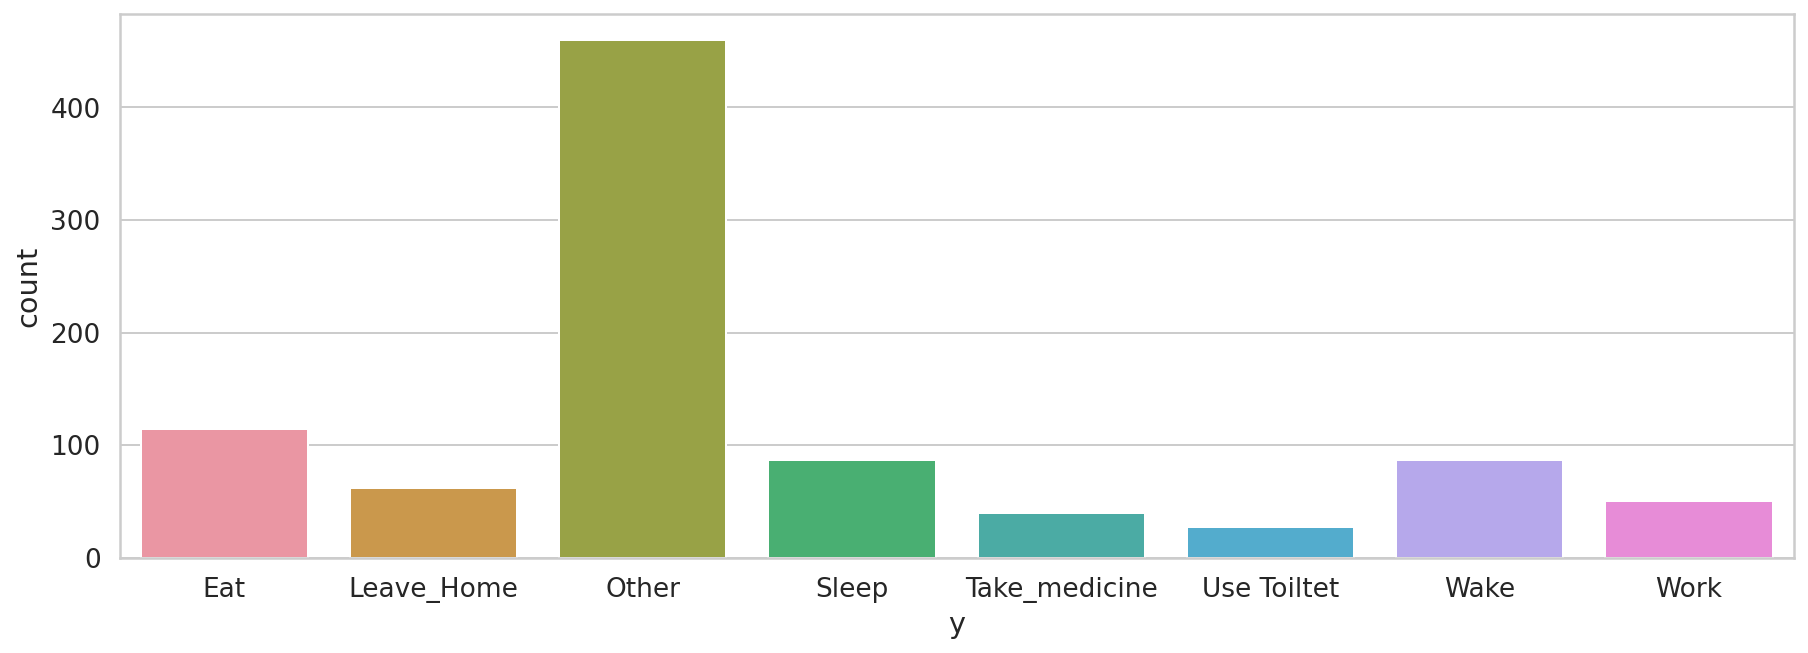

Test set distribution


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


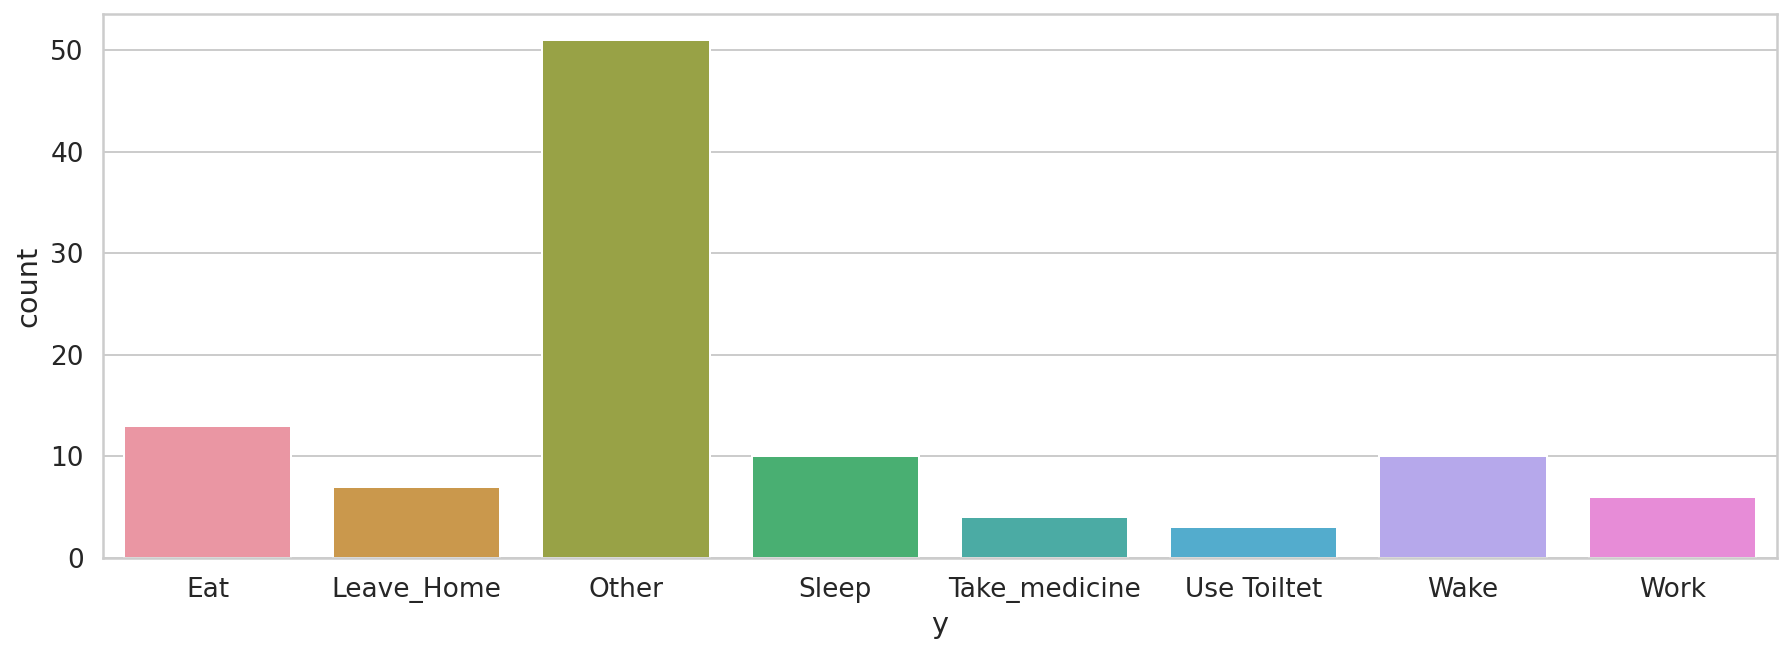

Activity accuracy training set
--------------------------------------------------------------------------------
29/29 [==============================] - 35s 1s/step
Classwise accuracy: 
Model accuracy for predicting Eat: 0/114 || 0.0%
Model accuracy for predicting Leave_Home: 14/62 || 22.58%
Model accuracy for predicting Other: 78/460 || 16.96%
Model accuracy for predicting Sleep: 1/87 || 1.15%
Model accuracy for predicting Take_medicine: 22/40 || 55.0%
Model accuracy for predicting Use Toiltet: 0/27 || 0.0%
Model accuracy for predicting Wake: 52/87 || 59.77%
Model accuracy for predicting Work: 1/50 || 2.0%
------------------------------------------------------------------------------------------------------------------------


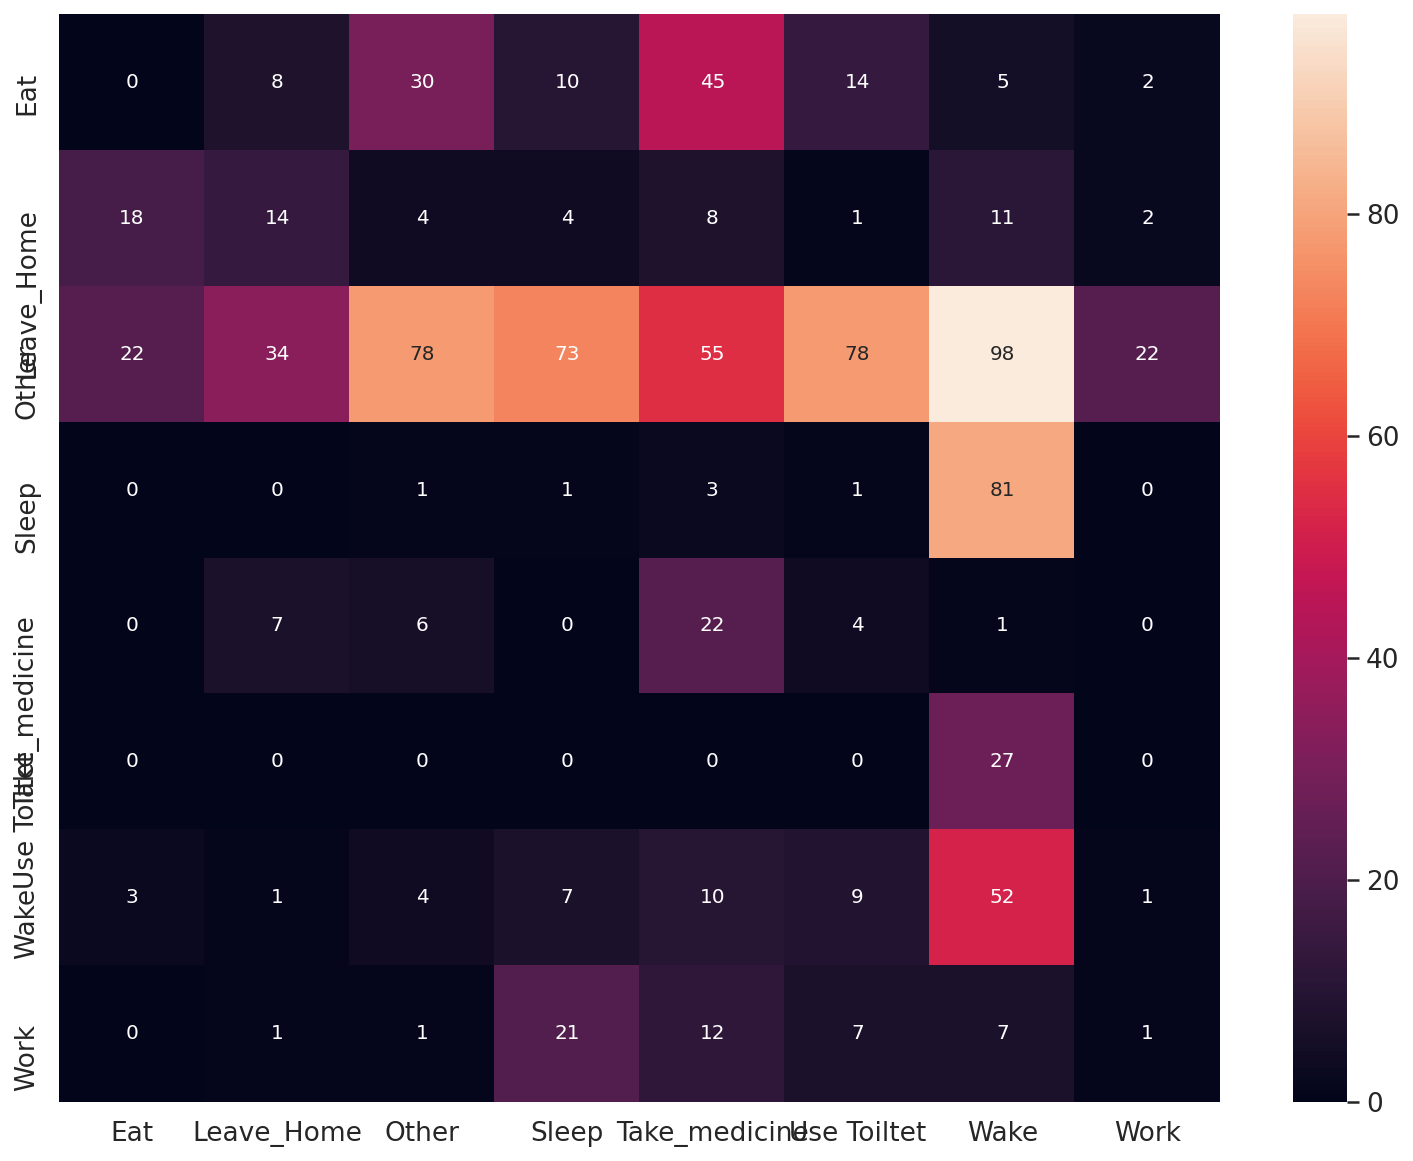

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
4/4 [==============================] - 4s 919ms/step
Classwise accuracy: 
Model accuracy for predicting Eat: 0/13 || 0.0%
Model accuracy for predicting Leave_Home: 0/7 || 0.0%
Model accuracy for predicting Other: 6/51 || 11.76%
Model accuracy for predicting Sleep: 0/10 || 0.0%
Model accuracy for predicting Take_medicine: 2/4 || 50.0%
Model accuracy for predicting Use Toiltet: 0/3 || 0.0%
Model accuracy for predicting Wake: 5/10 || 50.0%
Model accuracy for predicting Work: 0/6 || 0.0%
------------------------------------------------------------------------------------------------------------------------


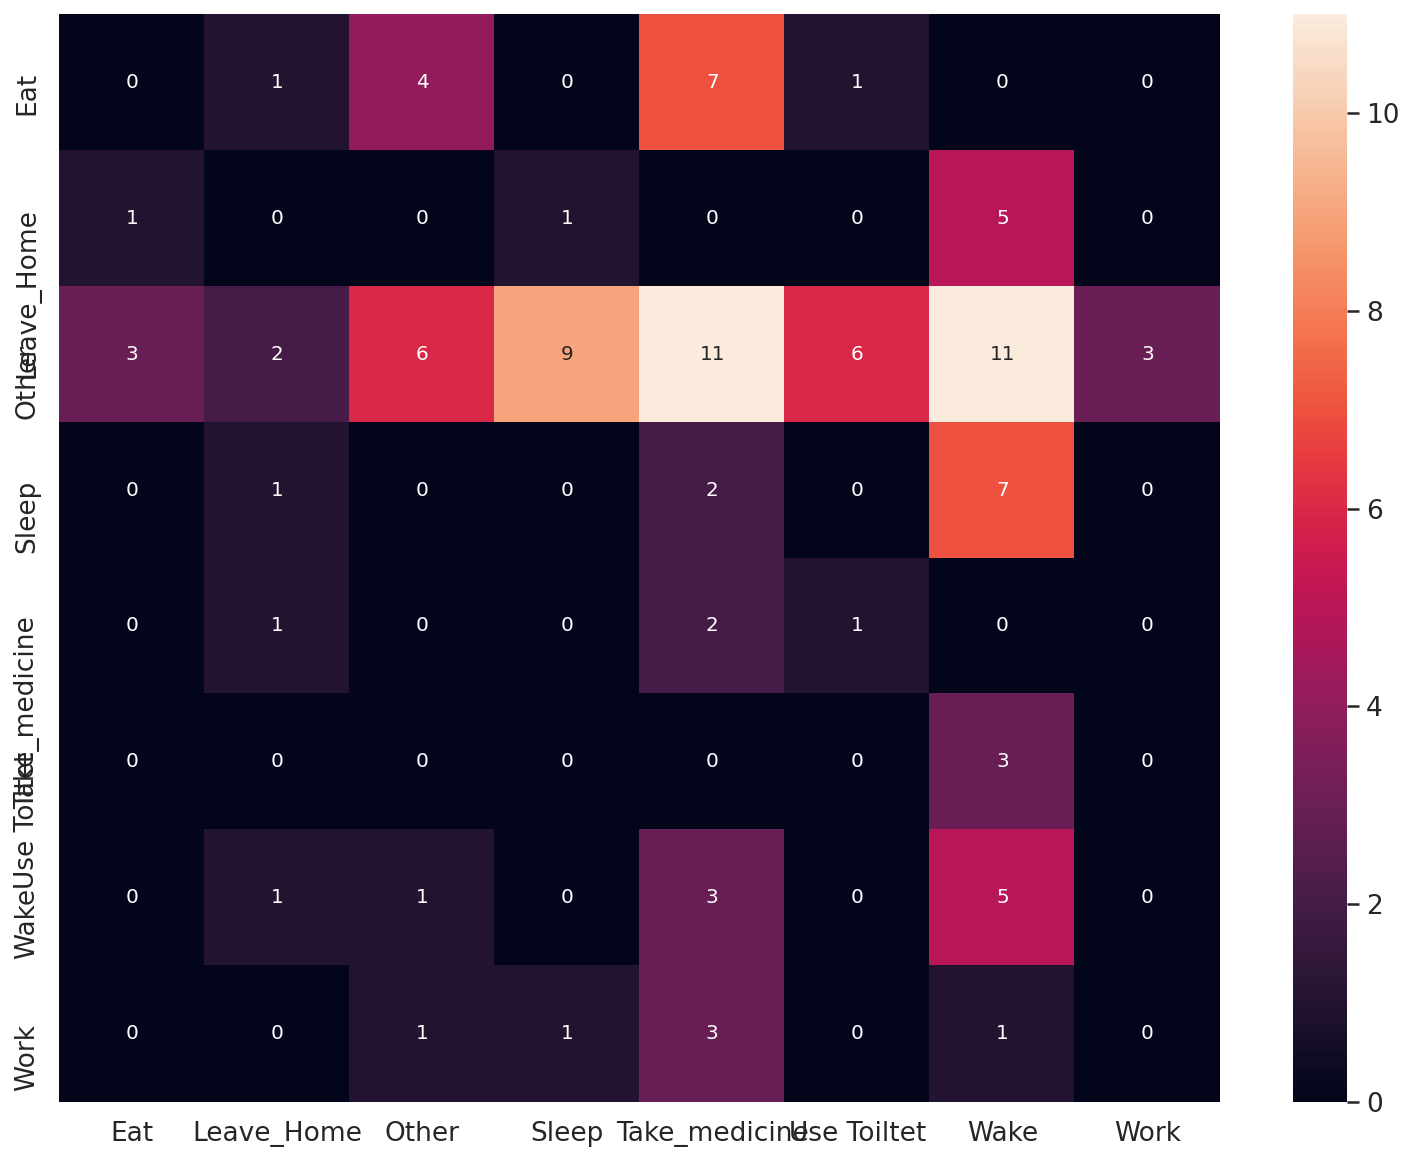

------------------------------------------------------------------------------------------------------------------------
Fold >> 1
Begin training ...
Epoch 1/6
10/10 [==============================] - 115s 11s/step - loss: 1.9860 - accuracy: 0.4747 - val_loss: 1.7019 - val_accuracy: 0.4497
Epoch 2/6
10/10 [==============================] - 114s 11s/step - loss: 1.5873 - accuracy: 0.5084 - val_loss: 1.5842 - val_accuracy: 0.4497
Epoch 3/6
10/10 [==============================] - 113s 11s/step - loss: 1.4816 - accuracy: 0.5236 - val_loss: 1.4716 - val_accuracy: 0.4966
Epoch 4/6
10/10 [==============================] - 113s 11s/step - loss: 1.3088 - accuracy: 0.5794 - val_loss: 1.2480 - val_accuracy: 0.5235
Epoch 5/6
10/10 [==============================] - 112s 11s/step - loss: 1.0898 - accuracy: 0.6216 - val_loss: 1.0871 - val_accuracy: 0.5705
Epoch 6/6
10/10 [==============================] - 113s 11s/step - loss: 0.9379 - accuracy: 0.6605 - val_loss: 0.9036 - val_accuracy: 0.6242
Begi

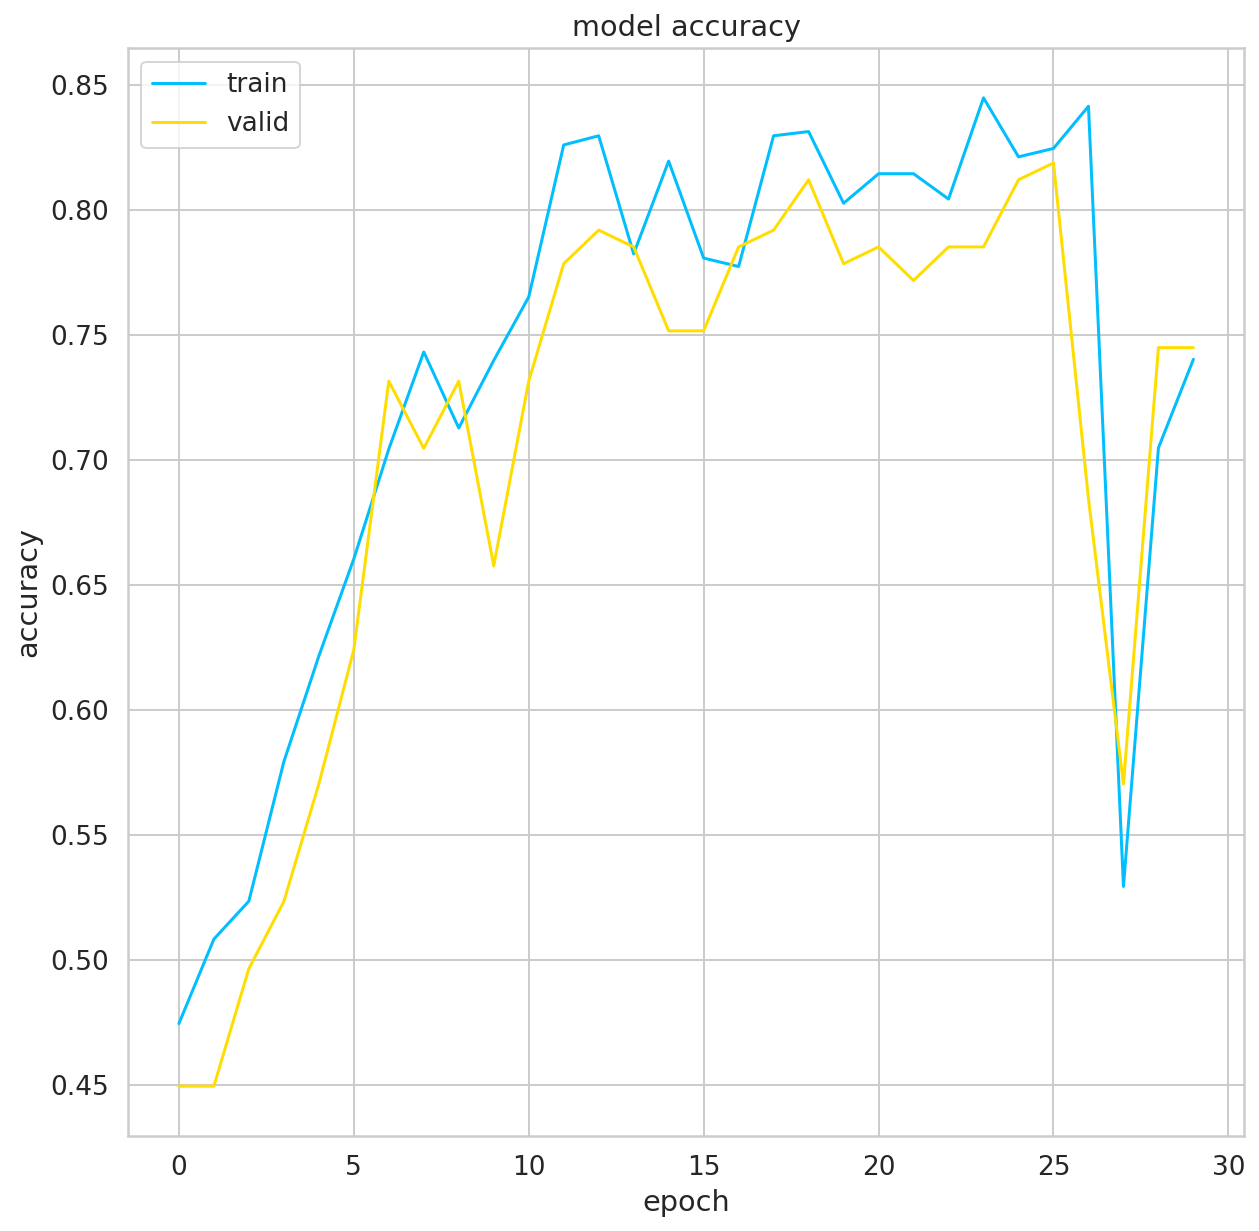

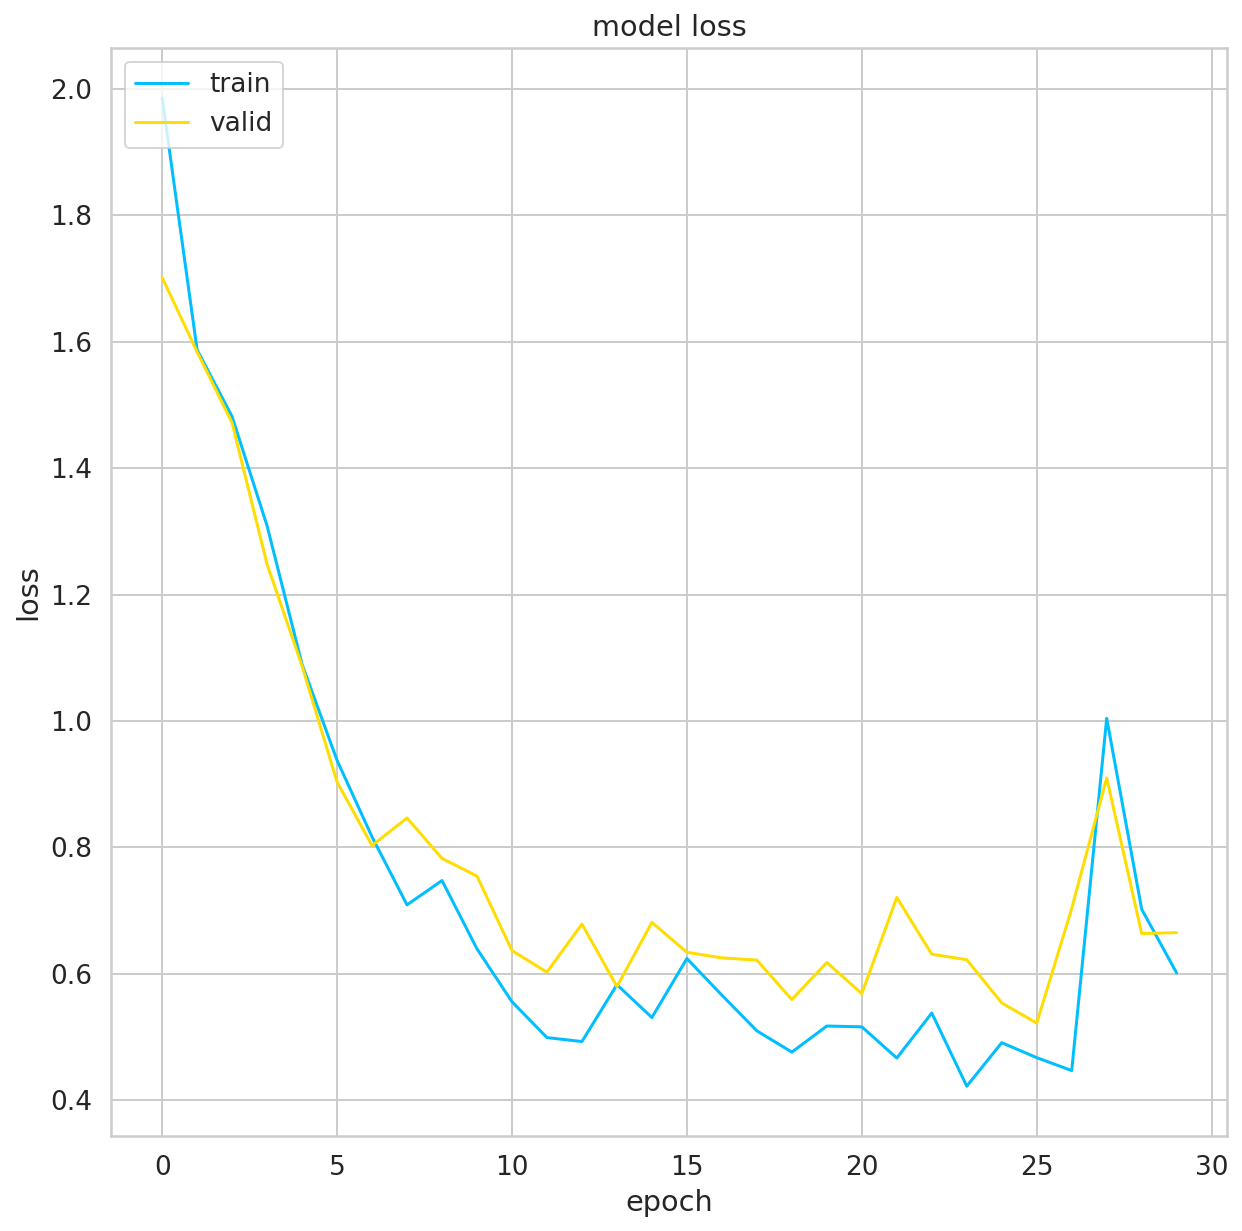


Test set evalutaion
2/2 [==============================] - 1s 617ms/step - loss: 0.8830 - accuracy: 0.6250
accuracy: 62.50%

Activity accuracy training set
--------------------------------------------------------------------------------
29/29 [==============================] - 34s 1s/step
Classwise accuracy: 
Model accuracy for predicting Eat: 0/114 || 0.0%
Model accuracy for predicting Leave_Home: 62/62 || 100.0%
Model accuracy for predicting Other: 416/460 || 90.43%
Model accuracy for predicting Sleep: 76/87 || 87.36%
Model accuracy for predicting Take_medicine: 29/40 || 72.5%
Model accuracy for predicting Use Toiltet: 0/27 || 0.0%
Model accuracy for predicting Wake: 63/87 || 72.41%
Model accuracy for predicting Work: 45/50 || 90.0%
------------------------------------------------------------------------------------------------------------------------


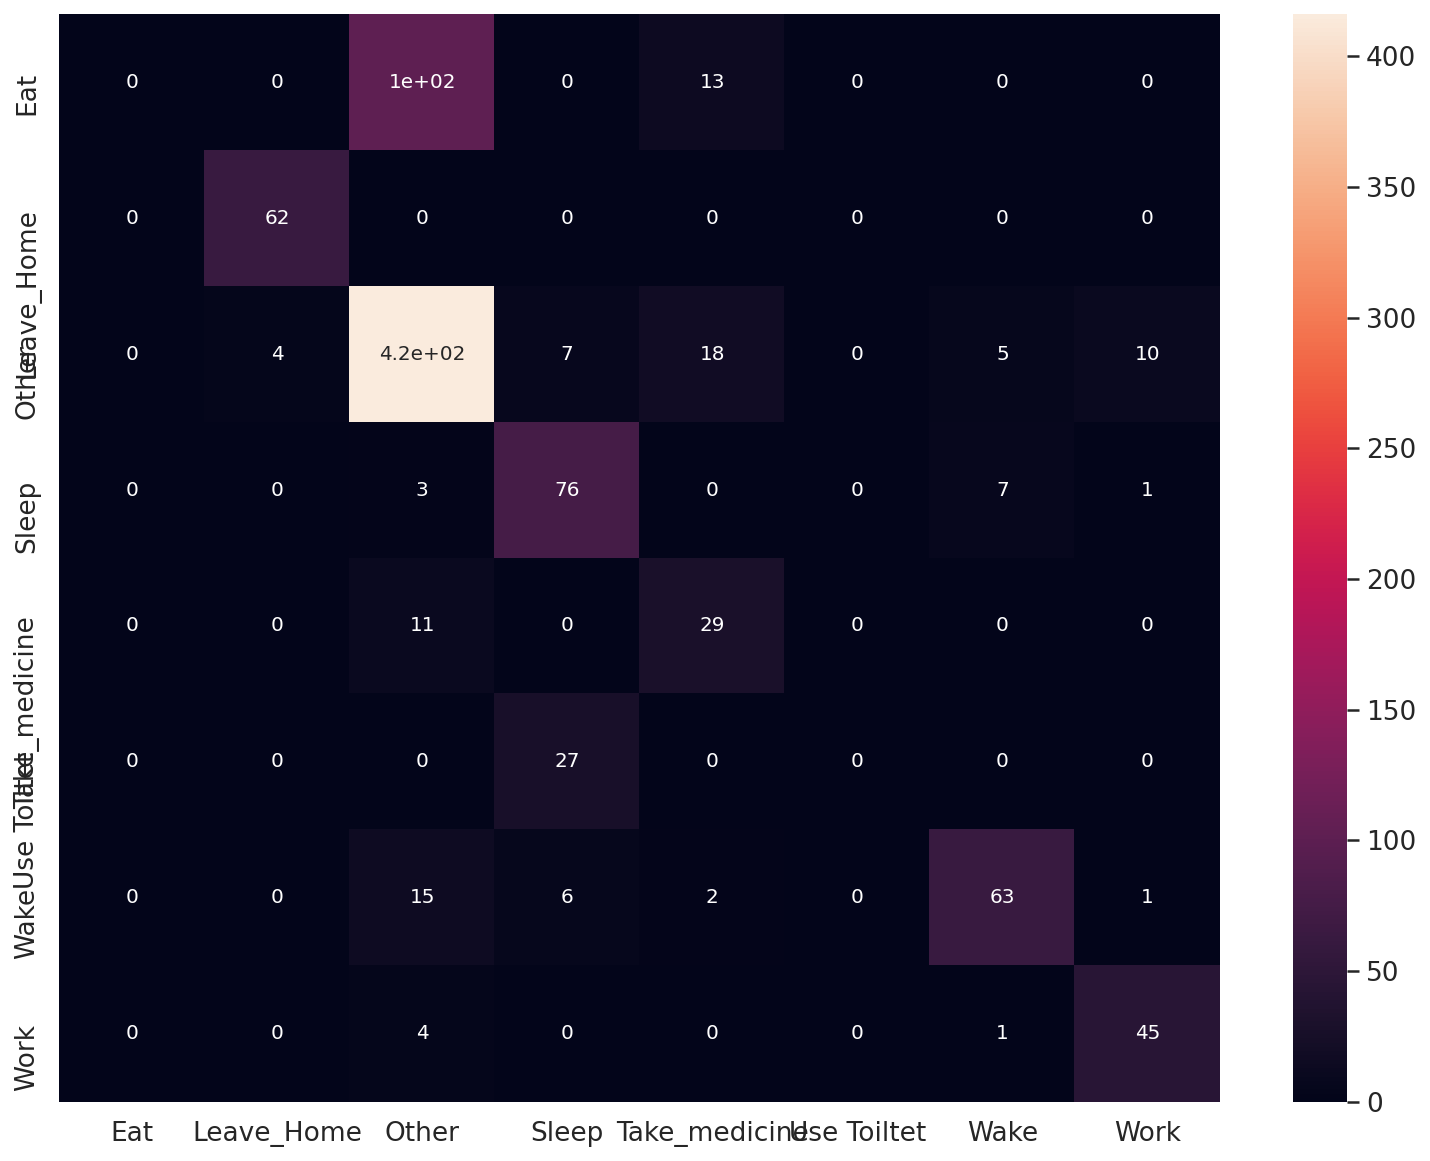

------------------------------------------------------------------------------------------------------------------------

Activity accuracy test set
--------------------------------------------------------------------------------
4/4 [==============================] - 4s 926ms/step
Classwise accuracy: 
Model accuracy for predicting Eat: 0/13 || 0.0%
Model accuracy for predicting Leave_Home: 7/7 || 100.0%
Model accuracy for predicting Other: 40/51 || 78.43%
Model accuracy for predicting Sleep: 7/10 || 70.0%
Model accuracy for predicting Take_medicine: 2/4 || 50.0%
Model accuracy for predicting Use Toiltet: 0/3 || 0.0%
Model accuracy for predicting Wake: 4/10 || 40.0%
Model accuracy for predicting Work: 5/6 || 83.33%
------------------------------------------------------------------------------------------------------------------------


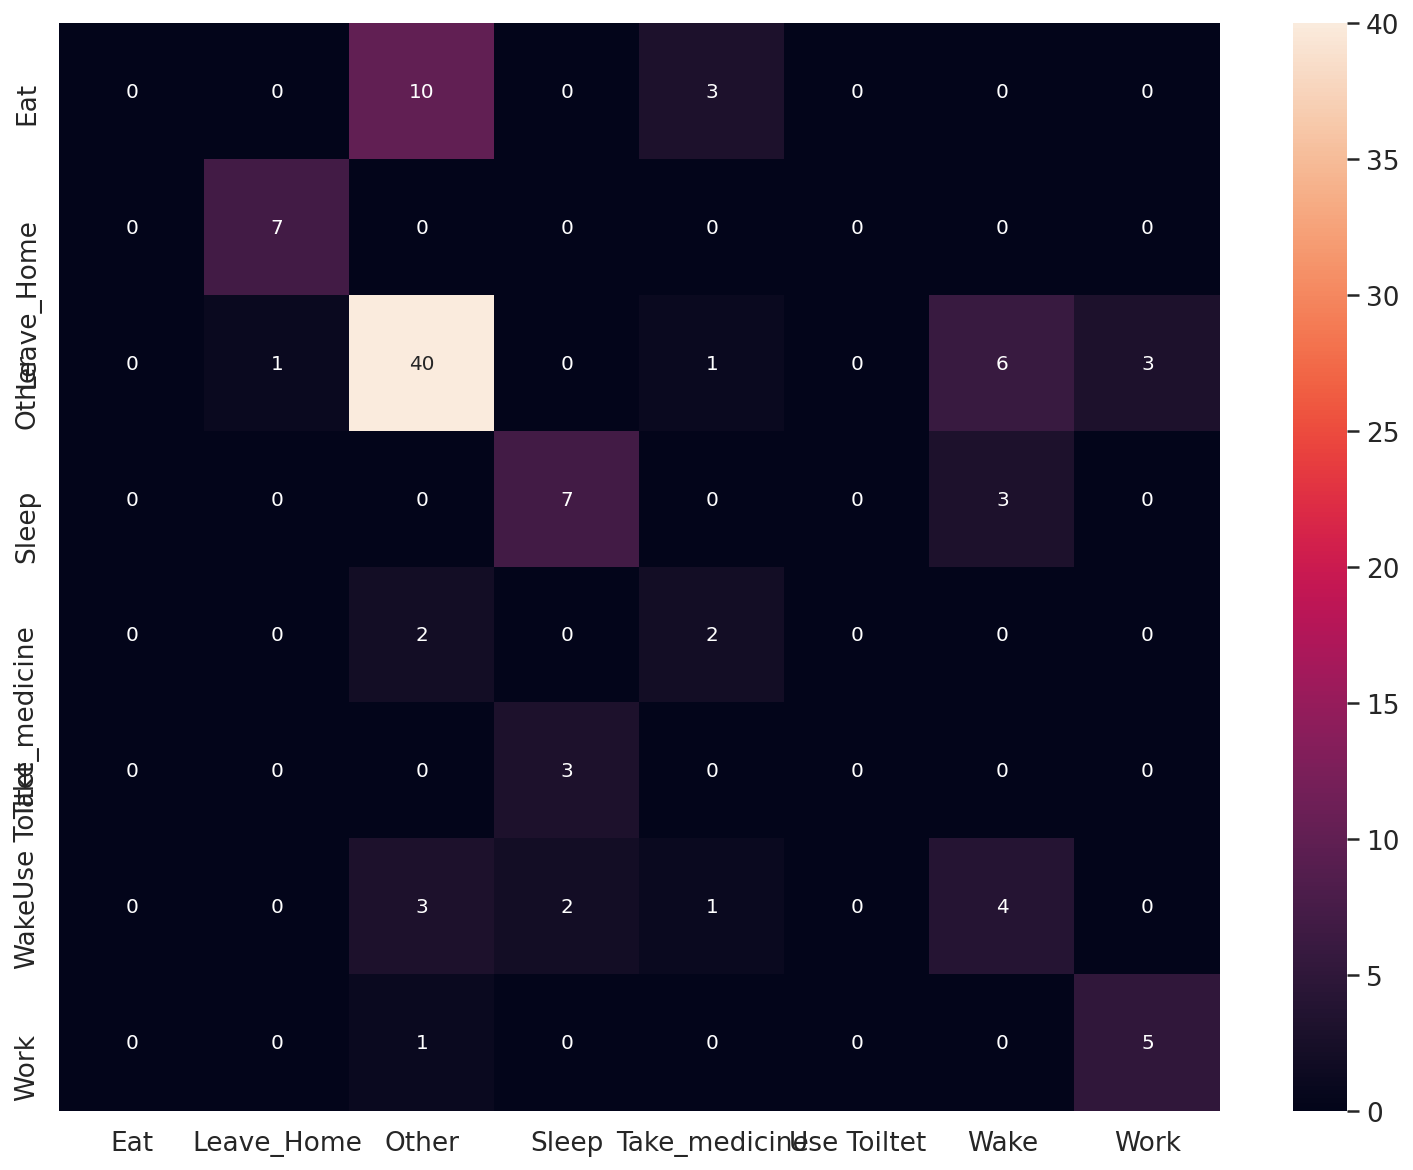

------------------------------------------------------------------------------------------------------------------------


In [ ]:
#GO
run(X, y, idx2act, model, 'biLSTM_EP1', 6)